In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

### Dataset Loading

In [2]:
import json, gzip

class MNIST_Dataset(Dataset):
    def __init__(self, json_data) -> None:
        self.features = [torch.FloatTensor(i['image']).view(28,28) for i in json_data]
        self.labels = [torch.LongTensor([i['label']]) for i in json_data]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = None
dev_dataset = None
test_dataset = None

with gzip.open('mnist_rowmajor.jsonl.gz') as file:
    trainval_data = []
    test_data = []

    for sample in [json.loads(line) for line in file]:
        sample['image'] = sample['image']
        if sample['split'] == 'train':
            trainval_data.append(sample)
        else:
            test_data.append(sample)

    train_dataset = MNIST_Dataset(trainval_data[:50000])
    dev_dataset = MNIST_Dataset(trainval_data[50000:])
    test_dataset = MNIST_Dataset(test_data)

In [3]:
BATCH_SIZE = 200

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Question 2b

In [4]:
class LinearAutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        pred_x = self.decoder(z)
        return pred_x
    
    def forward(self, x, detach = False):
        pred_x = self.decode(self.encode(x.view(-1,28*28)))
        if detach:
            pred_x = pred_x.cpu().detach()
        return pred_x.view(-1,28,28)

In [5]:
class ConvAutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(1, 5, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(5, 10, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1000, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 1000),
            nn.Unflatten(1, (10,10,10)),
            nn.ReLU(),
            nn.ConvTranspose2d(10, 5, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(5, 1, kernel_size=4, stride=2),
            nn.Sigmoid()
        )

    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        pred_x = self.decoder(z)
        return pred_x
    
    def forward(self, x, detach = False):
        pred_x = self.decode(self.encode(x.view(-1,1,28,28)))
        if detach:
            pred_x = pred_x.cpu().detach()
        return pred_x.view(-1,28,28)

In [6]:
def train_encoder(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, num_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Dev":^10}')
    # epoch loop
    for epoch in range(num_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        total_loss = 0
        total_num = 0
        for x, _ in train_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # calculate gradients
            loss = criterion(pred_x, x)
            loss.backward()
            # update statistics
            total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        print(f'{total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, _ in dev_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # update statistics
            total_loss += criterion(pred_x, x).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')

In [7]:
encoder_linear = LinearAutoEncoder().cuda()
train_encoder(encoder_linear, nn.BCELoss(), optim.Adam(encoder_linear.parameters(), lr=0.01), 10)

             Train       Dev    
Epoch 1     0.21250    0.15759  
Epoch 2     0.14573    0.13604  
Epoch 3     0.13154    0.12697  
Epoch 4     0.12584    0.12307  
Epoch 5     0.12294    0.12113  
Epoch 6     0.12131    0.12004  
Epoch 7     0.12012    0.11967  
Epoch 8     0.11920    0.11847  
Epoch 9     0.11864    0.11854  
Epoch 10    0.11782    0.11820  


In [8]:
encoder_conv = ConvAutoEncoder().cuda()
train_encoder(encoder_conv, nn.BCELoss(), optim.Adam(encoder_conv.parameters(), lr=0.01), 10)

             Train       Dev    
Epoch 1    

c:\Github Projects\.venv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


 0.21097    0.15003  
Epoch 2     0.14116    0.13362  
Epoch 3     0.12956    0.12601  
Epoch 4     0.12298    0.11991  
Epoch 5     0.11962    0.11784  
Epoch 6     0.11749    0.11664  
Epoch 7     0.11605    0.11604  
Epoch 8     0.11501    0.11450  
Epoch 9     0.11415    0.11338  
Epoch 10    0.11337    0.11324  


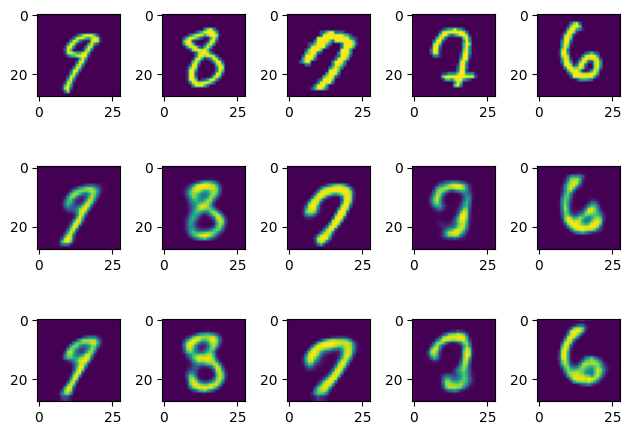

In [9]:
import random
fig, (row1, row2, row3) = plt.subplots(3, 5)

for i in range(5):
    x = dev_dataset[random.randint(0,10000-1)][0].cuda()
    x_pred_linear = encoder_linear.forward(x, detach=True).view(28,28)
    x_pred_conv = encoder_conv.forward(x, detach=True).view(28,28)

    row1[i].imshow(x.cpu())
    row2[i].imshow(x_pred_linear.cpu())
    row3[i].imshow(x_pred_conv.cpu())

plt.tight_layout()
plt.show()

### Question 2c

In [16]:
class BaselineClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.zeros(10)
    
    def forward(self, x):
        pred_y = torch.zeros(x.shape[0], 10)
        pred_y[:,self.w.argmax()] = 1
        return pred_y

In [17]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )
    
    def forward(self, x):
        return self.layers(x.view(-1,28*28))

In [27]:
def train_baseline(model: BaselineClassifier, criterion: nn.Module, num_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Test":^10}')
    # epoch loop
    for epoch in range(num_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
            # backward pass
            for y_i in y:
                model.w[y_i] += 1
        print(f'{total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')

In [28]:
def train_classifier(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, num_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Test":^10}')
    # epoch loop
    for epoch in range(num_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            z = encoder_linear.forward(x, detach=True)
            pred_y = model.forward(z)
            # calculate gradients
            loss = criterion(pred_y, y)
            loss.backward()
            # update statistics
            total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        print(f'{total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            z = encoder_linear.forward(x, detach=True)
            pred_y = model.forward(z)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')

In [29]:
classifier_base = BaselineClassifier()
train_baseline(classifier_base, nn.MultiMarginLoss(), 10)

             Train       Test   
Epoch 1     0.88862    0.88650  
Epoch 2     0.88810    0.88650  
Epoch 3     0.88810    0.88650  
Epoch 4     0.88810    0.88650  
Epoch 5     0.88810    0.88650  
Epoch 6     0.88810    0.88650  
Epoch 7     0.88810    0.88650  
Epoch 8     0.88810    0.88650  
Epoch 9     0.88810    0.88650  
Epoch 10    0.88810    0.88650  


In [31]:
classifier_linear = LinearClassifier()
train_classifier(classifier_linear, nn.MultiMarginLoss(), optim.Adam(classifier_linear.parameters(), lr=0.01), 10)

             Train       Test   
Epoch 1     0.05717    0.03677  
Epoch 2     0.02926    0.03346  
Epoch 3     0.02665    0.02892  
Epoch 4     0.02398    0.03016  
Epoch 5     0.02344    0.03082  
Epoch 6     0.02353    0.02981  
Epoch 7     0.02145    0.02868  
Epoch 8     0.02241    0.02896  
Epoch 9     0.02204    0.03352  
Epoch 10    0.02078    0.03262  
